# Deep Learning for Computer Vision:  HW 2


## Computer Science: COMS W 4995 005


## Due: October 10, 2024

#### Problem

You are given the noisy XOR data generated for you below. Your task is to implement a multi-layer perceptron binary classifier with one hidden layer. For the activiation function of the hidden units use ReLu. For the loss function use a softplus on a linear output layer as we did in class. Randomly initialize the weight parameters for your network.

a) Implement each layer of the network as a separate function with both forward propagation and backpropagation. 

b) Train the network using stochastic gradient descent with mini-batches.  

c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points according to the label your classifier would assign them. For instance, if a sample point $x$ is classified as class = 1, then color the point blue, otherwise color the point orange.

d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units effects your solution.

e) Try at least two different learning schedules. For instance, you can start with a constant learning rate and see how that converges. Then, you can repeat everything by using a learning schedule that decays with time.

f) Try choosing your own loss function (**without asking me or the TAs what you should choose**), repeating (d).

g) Now try with three input features, generating your own training and testing data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisy as before.) Use softplus loss. Do not try to show the decision regions, instead generate a test set in the same manner as the training set, classify the samples, and compute the classification accuracy.

h) Using your data from HW1 or any new data you curate if you don't think your HW1 data is appropriate for this assighnment, train your MLP using your training set (80%). Compute the error rate on your test set (20%). It's up to you how many hidden units to use. 

If you are struggling to get the network to converge, experiment with different learning rates.

Grading: a-d = 50%, e=10%, f=10%, g=10%, h=20%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.



## [LINK TO DATA SET](https://docs.google.com/spreadsheets/d/11XxdCvEcGQYfhJmcxF5CjSL88yCn2fErPaUqWyMANGI/edit?usp=sharing)

Let's start by importing some libraries.

In [133]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

Let's make up some noisy XOR data.

In [134]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1==1,x2==1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,1.068172,0.987122,0.0
1,0.129847,0.868899,1.0
2,-0.016900,-0.195644,0.0
3,0.821888,1.059593,0.0
4,0.249681,0.049327,0.0


Let's message this data into a numpy format.

In [135]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [136]:
# Sloppy function for plotting our data
def plot_data(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Now let's plot it.

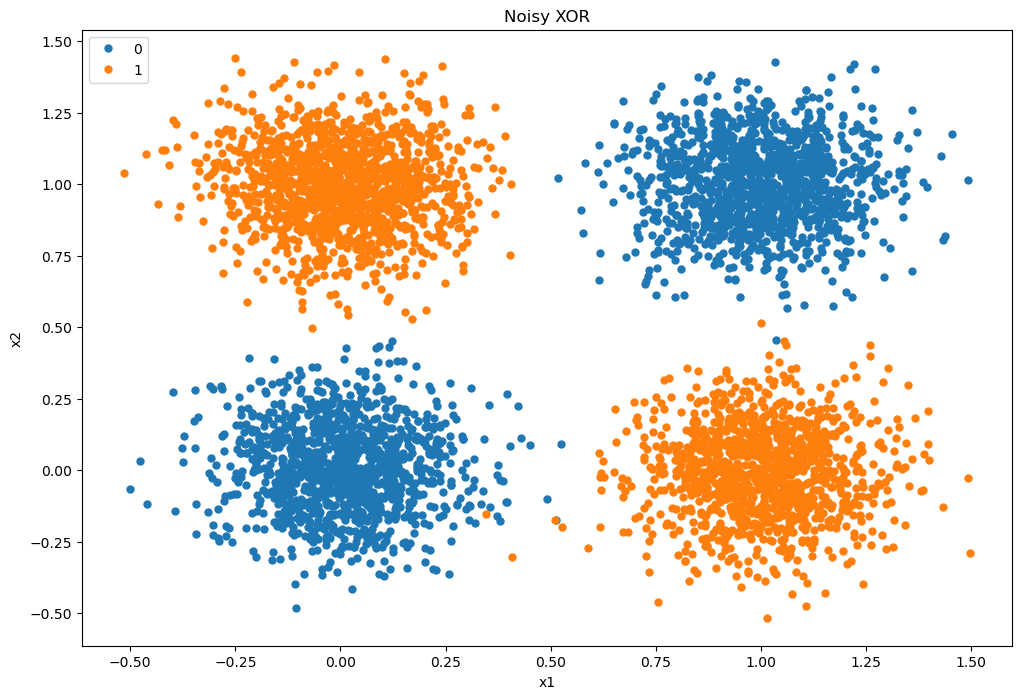

In [137]:
plot_data(X, y)

Now let's create functions for forward and backward prop through the layers and we are off...

## a) Layer Creation

In [138]:
import numpy as np

# activation function is relu
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return np.where(z > 0, 1, 0)

def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)
    return Z1, A1, Z2, A2

def backward_propagation(X, y, Z1, A1, Z2, A2, W2):
    m = X.shape[0]
    
    dZ2 = A2 - y
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0) / m  
    db2 = np.matrix(db2).reshape(1, -1)  # ensures db2 is a row vector
    
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = np.multiply(dA1, relu_derivative(Z1))
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0) / m  
    db1 = np.matrix(db1).reshape(1, -1)  
    
    return dW1, db1, dW2, db2
# softplus loss
def softplus(z):
    return np.log(1 + np.exp(z))

def softplus_derivative(z):
    return 1 / (1 + np.exp(-z))

def sigmoid(z):
    z = np.clip(z, -500, 500)  # clipping the input range to prevent overflow
    return 1 / (1 + np.exp(-z))

## b) Training w/ Stochastic Descent

In [139]:
def train(X, y, hidden_units=16, learning_rate=0.01, epochs=1000, batch_size=64, lambda_=0.001):
    input_size = X.shape[1]
    
    # reshape y if its 1D
    if len(y.shape) == 1:
        y = y.reshape(-1, 1)  # Make sure y is 2D (n_samples, 1)

    output_size = y.shape[1]
    
    W1 = np.random.randn(input_size, hidden_units) * 0.01
    b1 = np.zeros((1, hidden_units))
    W2 = np.random.randn(hidden_units, output_size) * 0.01
    b2 = np.zeros((1, output_size))

    for epoch in range(epochs):
        # minibatch the gradient descent
        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            
            # forward prop
            Z1, A1, Z2, A2 = forward_propagation(X_batch, W1, b1, W2, b2)
            
            # backprop
            dW1, db1, dW2, db2 = backward_propagation(X_batch, y_batch, Z1, A1, Z2, A2, W2)
            
            W1 -= learning_rate * (dW1 + lambda_ * W1)
            b1 -= learning_rate * db1
            W2 -= learning_rate * (dW2 + lambda_ * W2)
            b2 -= learning_rate * db2

        if epoch % 100 == 0:
            print(f"Epoch {epoch} complete")

    return W1, b1, W2, b2

## c) Plot Decision Boundary

Epoch 0 complete
Epoch 100 complete
Epoch 200 complete
Epoch 300 complete
Epoch 400 complete
Epoch 500 complete
Epoch 600 complete
Epoch 700 complete
Epoch 800 complete
Epoch 900 complete


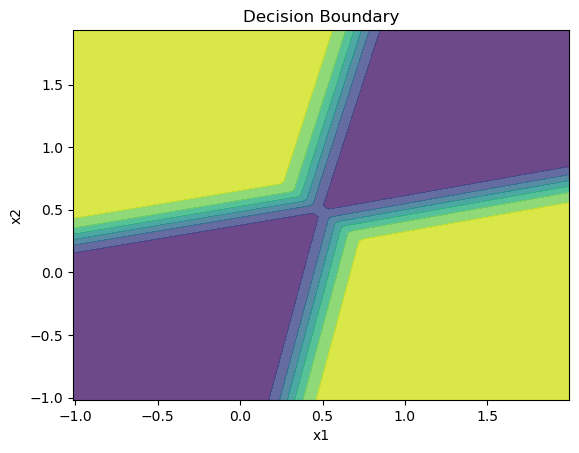

In [141]:
def plot_decision_boundary(W1, b1, W2, b2):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    _, _, _, probs = forward_propagation(grid, W1, b1, W2, b2)
    
    probs = probs.reshape(xx.shape)
    plt.contourf(xx, yy, probs, alpha=0.8)

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Decision Boundary')
    plt.show()

W1, b1, W2, b2 = train(X, y, hidden_units=16, epochs=1000)
plot_decision_boundary(W1, b1, W2, b2)

## d) Varying the Number of Hidden Units


 Using3 hidden units:
Epoch 0 complete
Epoch 100 complete
Epoch 200 complete
Epoch 300 complete
Epoch 400 complete
Epoch 500 complete
Epoch 600 complete
Epoch 700 complete
Epoch 800 complete
Epoch 900 complete


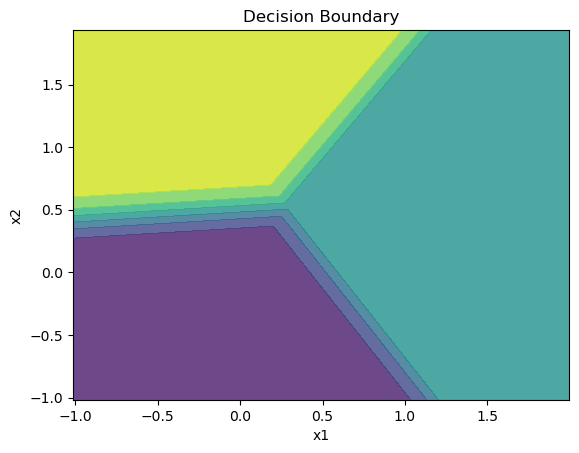


 Using16 hidden units:
Epoch 0 complete
Epoch 100 complete
Epoch 200 complete
Epoch 300 complete
Epoch 400 complete
Epoch 500 complete
Epoch 600 complete
Epoch 700 complete
Epoch 800 complete
Epoch 900 complete


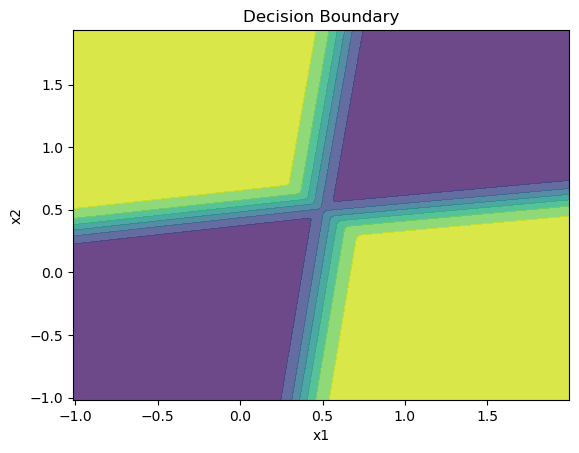


 Using512 hidden units:
Epoch 0 complete
Epoch 100 complete
Epoch 200 complete
Epoch 300 complete
Epoch 400 complete
Epoch 500 complete
Epoch 600 complete
Epoch 700 complete
Epoch 800 complete
Epoch 900 complete


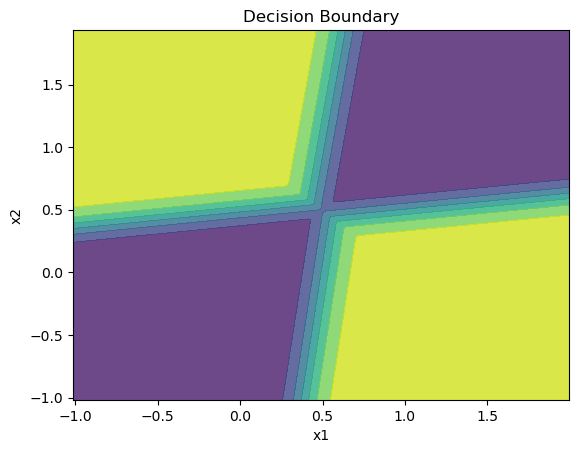

In [142]:
li = [3, 16, 512]

for hidden_units in li:
    print(f"\n Using{hidden_units} hidden units:")
    weight_1, bias_1, weight_2, bias_2 = train(X, y, hidden_units=hidden_units, epochs=1000)
    plot_decision_boundary(weight_1, bias_1, weight_2, bias_2)


## e) Varying Learning Schedules

epoch 0, loss: 0.9716479660982458, learning rate: 0.1
epoch 100, loss: 1.080402989502443, learning rate: 0.09090909090909091
epoch 200, loss: 1.0028826901576606, learning rate: 0.08333333333333334
epoch 300, loss: 1.1583218222473177, learning rate: 0.07692307692307693
epoch 400, loss: 1.1582216209497391, learning rate: 0.07142857142857144
epoch 500, loss: 1.0011217702568256, learning rate: 0.06666666666666667
epoch 600, loss: 0.9251405888064639, learning rate: 0.0625
epoch 700, loss: 1.004069058982398, learning rate: 0.058823529411764705
epoch 800, loss: 0.925571346206711, learning rate: 0.05555555555555556
epoch 900, loss: 1.158231028813411, learning rate: 0.052631578947368425


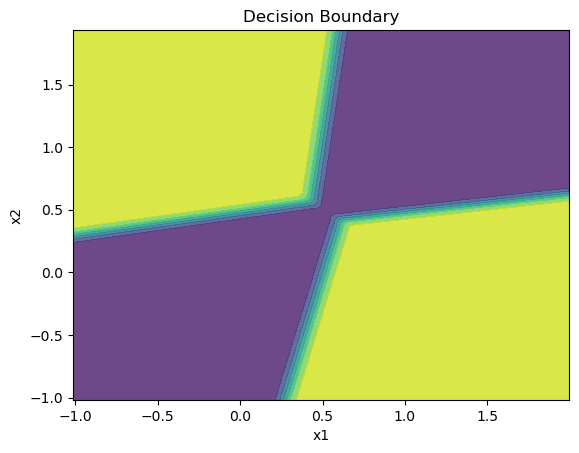

In [143]:
def train_with_decay(X, y, hidden_units=16, initial_rate=0.1, decay=0.001, epochs=1000, batch_size=64):
    np.random.seed(42)
    
    input_size = X.shape[1]
    output_size = 1
    
    W1 = np.random.randn(input_size, hidden_units) * 0.01
    b1 = np.zeros((1, hidden_units))
    W2 = np.random.randn(hidden_units, output_size) * 0.01
    b2 = np.zeros((1, output_size))
    
    for epoch in range(epochs):
        learning_rate = initial_rate / (1 + decay * epoch)
        
        permutation = np.random.permutation(X.shape[0])
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]
        
        for i in range(0, X.shape[0], batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]
            
            Z1, A1, Z2, A2 = forward_propagation(X_batch, W1, b1, W2, b2)
            
            dW1, db1, dW2, db2 = backward_propagation(X_batch, y_batch, Z1, A1, Z2, A2, W2)
            
            # update weights
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2
            b2 -= learning_rate * db2
        
        if epoch % 100 == 0:
            loss = np.mean(softplus(A2))
            print(f'epoch {epoch}, loss: {loss}, learning rate: {learning_rate}')
    
    return W1, b1, W2, b2

W1, b1, W2, b2 = train_with_decay(X, y, hidden_units=16, epochs=1000)
plot_decision_boundary(W1, b1, W2, b2)

## f) Custom Loss

Epoch 0 complete
Epoch 100 complete
Epoch 200 complete
Epoch 300 complete
Epoch 400 complete
Epoch 500 complete
Epoch 600 complete
Epoch 700 complete
Epoch 800 complete
Epoch 900 complete


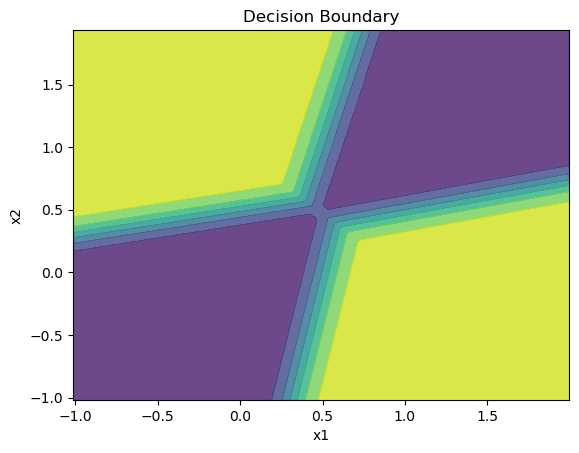

In [144]:
# I chose MSE for custom loss
def mse_loss(A2, y):
    return np.mean((A2 - y) ** 2)

def mse_loss_derivative(A2, y):
    return 2 * (A2 - y) / A2.size

def backward_propagation_mse(X, y, Z1, A1, Z2, A2, W2):
    m = X.shape[0]
    
    dZ2 = mse_loss_derivative(A2, y)
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    
    return dW1, db1, dW2, db2

W1, b1, W2, b2 = train(X, y, hidden_units=16, epochs=1000)
plot_decision_boundary(W1, b1, W2, b2)

## g) XOR with 3 Inputs

In [145]:
def generate_noisy_xor_3():
    data = pd.DataFrame(np.zeros((5000, 4)), columns=['x1', 'x2', 'x3', 'y'])

    for i in range(len(data.index)):
        x1 = 1.0 * random.randint(0, 1)
        x2 = 1.0 * random.randint(0, 1)
        x3 = 1.0 * random.randint(0, 1)
        y = 1.0 * ((x1 + x2 + x3) == 1)
        
        x1 = x1 + 0.15 * np.random.normal()
        x2 = x2 + 0.15 * np.random.normal()
        x3 = x3 + 0.15 * np.random.normal()
        
        data.iloc[i, 0] = x1
        data.iloc[i, 1] = x2
        data.iloc[i, 2] = x3
        data.iloc[i, 3] = y
    
    return data

data_3 = generate_noisy_xor_3()
X_3 = np.matrix(data_3.iloc[:, 0:3].values)
y_3 = np.matrix(data_3.iloc[:, 3:4].values)

split_index = int(0.8 * X_3.shape[0])
X_train_3, X_test_3 = X_3[:split_index], X_3[split_index:]
y_train_3, y_test_3 = y_3[:split_index], y_3[split_index:]

# train on 3 features
W1, b1, W2, b2 = train(X_train_3, y_train_3, hidden_units=16, epochs=1000)

_, _, _, y_pred_test_3 = forward_propagation(X_test_3, W1, b1, W2, b2)
accuracy = np.mean((y_pred_test_3 > 0.5) == y_test_3)
print(f"Accuracy on test set with 3 features: {accuracy * 100:.2f}%")

Epoch 0 complete
Epoch 100 complete
Epoch 200 complete
Epoch 300 complete
Epoch 400 complete
Epoch 500 complete
Epoch 600 complete
Epoch 700 complete
Epoch 800 complete
Epoch 900 complete
Accuracy on test set with 3 features: 98.60%


## Testing

In [146]:
import numpy as np
import pandas as pd

df = pd.read_csv('DEEPLEARNINGHW1.csv') 

X = df[['Length', 'Age']].values  
y = np.where(df['Species'] == 'Bass', 0, 1)  

np.random.seed(0)
indices = np.random.permutation(len(X))
train_size = int(0.8 * len(X))

X_train = X[indices[:train_size]]
y_train = y[indices[:train_size]]
X_test = X[indices[train_size:]]
y_test = y[indices[train_size:]]


In [147]:
def compute_error_rate(y_true, y_pred):
    errors = np.sum(y_true != y_pred)
    error_rate = errors / len(y_true)
    return error_rate

In [148]:
print(f"Training on {X_train.shape[0]} samples with {X_train.shape[1]} features.")
W1, b1, W2, b2 = train(X_train, y_train, hidden_units=512, epochs=1000)

_, _, _, predictions_test = forward_propagation(X_test, W1, b1, W2, b2)

predictions_binary = (predictions_test >= 0.5).astype(int)
predictions_binary = predictions_binary.flatten()

error_rate = compute_error_rate(y_test, predictions_binary)
print(f"Test error rate: {error_rate * 100:.2f}%")

# print("W1:", W1)
# print("W2:", W2)



Training on 160 samples with 2 features.
Epoch 0 complete
Epoch 100 complete
Epoch 200 complete
Epoch 300 complete
Epoch 400 complete
Epoch 500 complete
Epoch 600 complete
Epoch 700 complete
Epoch 800 complete
Epoch 900 complete
Test error rate: 7.50%
